<a href="https://colab.research.google.com/github/ali-rehman-ML/EdgeSeg/blob/main/notebooks/Export_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 15.3 MB/s eta 0:00:00


In [ ]:
!pip install onnxruntime




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 16.9 MB/s eta 0:00:00


In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

print(onnx.__version__)
print(ort.__version__)
print(np.__version__)

1.16.1
1.18.1
1.26.4


In [ ]:
import torch

model=torch.load('/content/drive/MyDrive/EdgeSeg/Model Weights/segformer-b0-city.pth')
model.cuda()

ModuleNotFoundError: No module named 'transformers'

In [ ]:
dummy_input=torch.randn(1,3,1024,1024)
input_names = [ "inputseg" ]
output_names = [ "outputseg" ]


In [ ]:
torch.onnx.export(model,
                  dummy_input,
                  "segformer-b1.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

In [ ]:
input=inp.detach().numpy()#torch.randn(1,3,1024,1024).cpu().detach().numpy()
print(input.shape)


(1, 3, 1024, 1024)


In [ ]:
import onnxruntime as onnxrt
import numpy as np

onnx_session= onnxrt.InferenceSession("/content/drive/MyDrive/EdgeSeg/Model Weights/resnet18_int8.onnx")
onnx_inputs= onnx_session.get_inputs()[0].name



In [ ]:
import time
t1=time.time()
onnx_output = onnx_session.run(None, {onnx_inputs: input.astype(np.float32)})
t2=time.time()
print(t2-t1)

print(onnx_output[0].shape)

2.526672124862671
(1, 19, 256, 256)


In [ ]:
from onnxruntime import quantization
import onnx
model_onnx = onnx.load('/content/drive/MyDrive/EdgeSeg/Model Weights/segformer-b1.onnx')
onnx.checker.check_model(model_onnx)

In [ ]:
model_prep_path = 'resnet18_prep.onnx'
model_fp32_path='/content/drive/MyDrive/EdgeSeg/Model Weights/segformer-b1.onnx'
quantization.shape_inference.quant_pre_process(model_fp32_path, model_prep_path, skip_symbolic_shape=False)


In [ ]:
import onnxruntime as ort
ort_provider = ['CUDAExecutionProvider']


ort_int8_sess = ort.InferenceSession('/content/drive/MyDrive/EdgeSeg/Model Weights/resnet18_int8.onnx', providers=ort_provider)


In [ ]:
!cp /content/segformer-b1.onnx /content/drive/MyDrive/EdgeSeg/Model\ Weights/

In [ ]:
ort_inputs = {ort_int8_sess.get_inputs()[0].name: input.astype(np.float32)}

# ort_int8_outs = ort_int8_sess.run(None, ort_inputs)[0]

In [ ]:
%timeit ort_int8_sess.run(None, ort_inputs)[0]

4.27 s ± 1.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


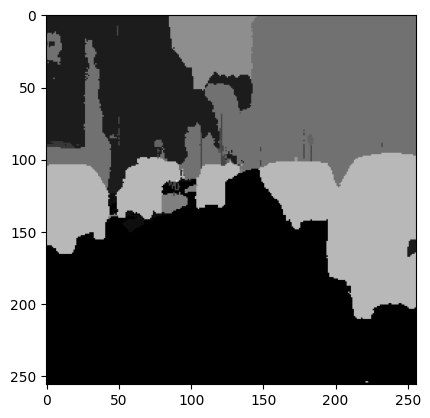

In [ ]:
o=np.argmax(ort_int8_outs,axis=1)
plt.imshow(o[0],cmap='gray')
plt.show()

In [ ]:
onnx_output = onnx_session.run(None, {onnx_inputs: input.astype(np.float32)})

print(onnx_output[0].shape)

(1, 19, 256, 256)


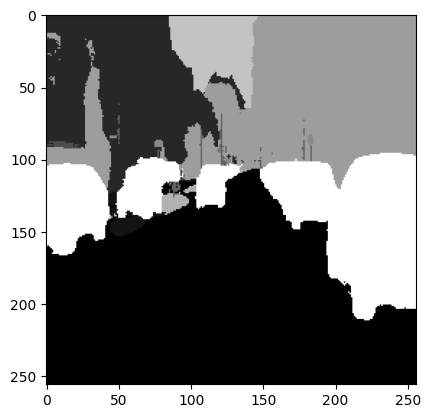

In [ ]:
o=np.argmax(onnx_output[0],axis=1)
plt.imshow(o[0],cmap='gray')
plt.show()

In [ ]:
from torchvision.datasets import Cityscapes

dataset = Cityscapes(root='/content/drive/MyDrive/EdgeSeg/cityscapes', split='val', mode='fine', target_type='semantic')


In [ ]:
# prompt: create a q_dataset that contain a subste of dataset 50 samples

# Assuming 'dataset' is already defined as in the preceding code
import torch

q_dataset = torch.utils.data.Subset(dataset, range(1))  # Select the first 50 samples


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")


transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any other transformations here
])
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
feature_extractor.do_resize=True
feature_extractor.size=(1024,1024)



class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            inputs = feature_extractor(images=image, return_tensors="pt")
            inp=inputs["pixel_values"]
            image=inp.squeeze()
            label = self.transform(label)
        return image, label

custom_dataset = CustomDataset(q_dataset, transform=transform)

# dataloader = DataLoader(custom_dataset, batch_size=4, shuffle=True)

# # Now you can iterate over the dataloader
# for images, labels in dataloader:
#     # Your training loop here
#     print(images.shape, labels.shape)







/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
feature_extractor.do_resize=True
feature_extractor.size=(1024,1024)
from onnxruntime import quantization
import onnx




class QuntizationDataReader(quantization.CalibrationDataReader):
    def __init__(self, torch_ds, batch_size, input_name):

        self.torch_dl = torch.utils.data.DataLoader(torch_ds, batch_size=batch_size, shuffle=False)

        self.input_name = input_name
        self.datasize = len(self.torch_dl)

        self.enum_data = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):

        return pt_tensor.detach().cpu().numpy() if pt_tensor.requires_grad else pt_tensor.cpu().numpy()

    def get_next(self):
        batch = next(self.enum_data, None)

        if batch is not None:
          print(batch[0].shape)
          return {self.input_name: self.to_numpy(batch[0])}
        else:
          return None

    def rewind(self):
        self.enum_data = iter(self.torch_dl)

qdr = QuntizationDataReader(custom_dataset, batch_size=1, input_name=onnx_inputs)

In [ ]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType , quantize_dynamic

output_model='segformer_dynamic_int8.onnx'
quantize_dynamic(model_prep_path, output_model, weight_type=QuantType.QInt8, operators_to_quantize=['MatMul', 'Attention', 'LSTM', 'Gather', 'Transpose', 'EmbedLayerNormalization'])



TypeError: quantize_dynamic() got an unexpected keyword argument 'operators_to_quantize'

In [ ]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType

quantize_static(model_input=model_prep_path,
                model_output='mob_uint8.onnx',
                 extra_options=q_static_opts,
                calibration_data_reader=qdr,
                op_types_to_quantize=['MatMul', 'Attention', 'LSTM', 'Gather', 'Transpose', 'EmbedLayerNormalization'])


torch.Size([1, 3, 1024, 1024])


In [ ]:
!cp /content/new_segformer_int8.onnx /content/drive/MyDrive/EdgeSeg/Model\ Weights/

In [ ]:
!cp /content/segformerint8.onnx /content/drive/MyDrive/EdgeSeg/Model\ Weights/

In [ ]:
q_static_opts = {"ActivationSymmetric":False,
                 "WeightSymmetric":True}
if torch.cuda.is_available():
  q_static_opts = {"ActivationSymmetric":True,
                  "WeightSymmetric":True}


model_int8_path = 'segformer_int8.onnx'
quantized_model = quantization.quantize_static(model_input=model_prep_path,
                                               model_output=model_int8_path,
                                               calibration_data_reader=qdr,
                                               extra_options=q_static_opts,
                                               activation_type=quantization.QuantType.QInt8,
                                               weight_type=quantization.QuantType.QUInt8
                                               )

torch.Size([1, 3, 1024, 1024])


ValueError: ONNXRuntime quantization doesn't support data format:activation_type=QuantType.QInt8, weight_type=QuantType.QUInt8

[ 0  1  2  3  5  7  8  9 10 11 13 18]


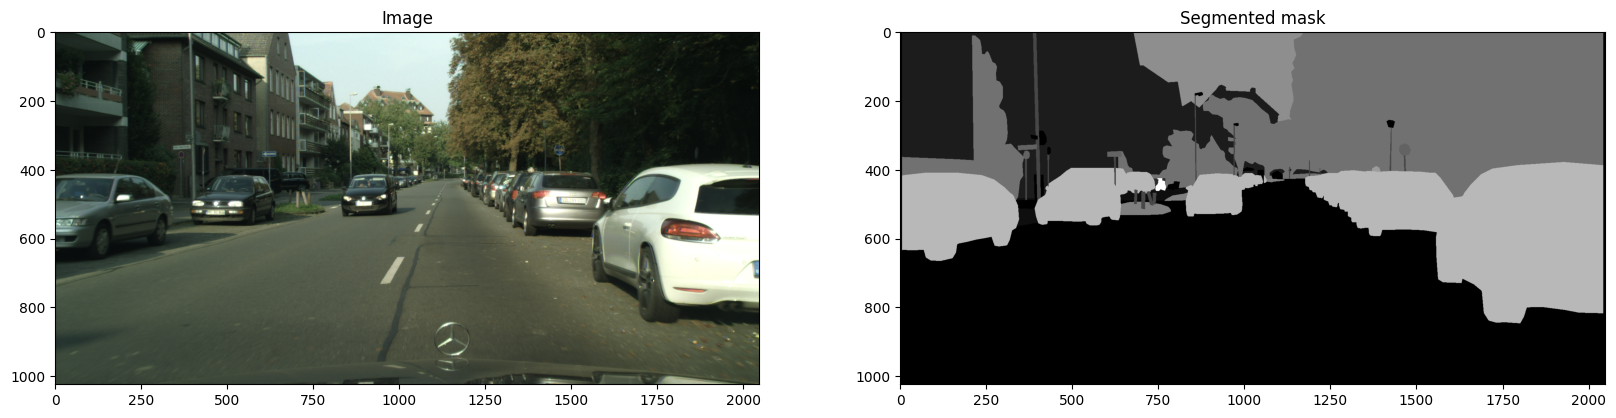

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the label map
label_map = np.array(
    (
        -1, -1, -1, -1, -1, -1, -1, 0,  # road 7
        1,  # sidewalk 8
        -1, -1, 2,  # building 11
        3,  # wall 12
        4,  # fence 13
        -1, -1, -1, 5,  # pole 17
        -1, 6,  # traffic light 19
        7,  # traffic sign 20
        8,  # vegetation 21
        9,  # terrain 22
        10,  # sky 23
        11,  # person 24
        12,  # rider 25
        13,  # car 26
        14,  # truck 27
        15,  # bus 28
        -1, -1, 16,  # train 31
        17,  # motorcycle 32
        18  # bicycle 33
    )
)

# Function to map the original image values to the new range
def map_image_values(image, label_map):
    mapped_image = np.copy(image)
    for original_value in range(len(label_map)):
        if label_map[original_value] != -1:
            mapped_image[image == original_value] = label_map[original_value]
        else:
            mapped_image[image == original_value] = 0  # Optionally map -1 values to 0
    return mapped_image

img, smnt = dataset[170]
inp=np.array(img)


smnt=map_image_values(np.array(smnt),label_map)
print(np.unique(smnt))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns, adjust figsize as needed

ax[0].imshow(inp)
ax[0].set_title('Image')

ax[1].imshow(smnt, cmap='gray')
ax[1].set_title('Segmented mask')

plt.show()

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
feature_extractor.do_resize=True
feature_extractor.size=(1024,1024)
inputs = feature_extractor(images=img, return_tensors="pt")
inp=inputs["pixel_values"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [ ]:
import time

with torch.no_grad():
  start_time = time.time()
  outputs = model(inp)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 9.32 seconds


In [ ]:
import torch.nn.functional as F

def resize(
    x: torch.Tensor,
    size: any or None = None,
    scale_factor: list[float] or None = None,
    mode: str = "bicubic",
    align_corners: bool or None = False,
) -> torch.Tensor:
    if mode in {"bilinear", "bicubic"}:
        return F.interpolate(
            x,
            size=size,
            scale_factor=scale_factor,
            mode=mode,
            align_corners=align_corners,
        )
    elif mode in {"nearest", "area"}:
        return F.interpolate(x, size=size, scale_factor=scale_factor, mode=mode)
    else:
        raise NotImplementedError(f"resize(mode={mode}) not implemented.")

In [ ]:
smnt.shape[-2:]

(1024, 2048)

In [ ]:
o=torch.argmax(outputs.logits,dim=1).squeeze().cpu().detach().numpy()


In [ ]:
r_o=resize(outputs.logits,size=smnt.shape[-2:])


In [ ]:
output = (torch.argmax(r_o, dim=1).cpu().numpy()[0])
output.shape

(1024, 2048)

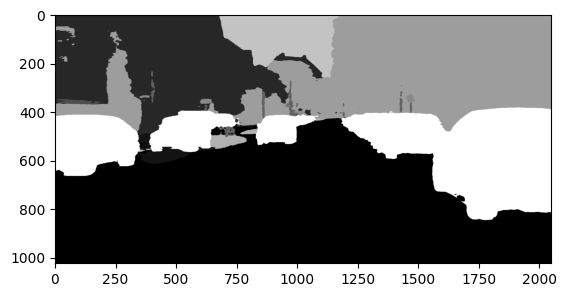

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(output,cmap='gray')
plt.show()

In [ ]:
import numpy as np

def calculate_iou_and_miou(ground_truth, prediction, num_classes):
    """
    Calculate the IoU for each class and the mIoU for a single image.

    Parameters:
    - ground_truth: 2D numpy array, ground truth mask
    - prediction: 2D numpy array, predicted mask
    - num_classes: int, number of classes

    Returns:
    - class_iou: dictionary, IoU for each class
    - miou: float, mean IoU across all classes
    """
    class_iou = {}
    ious = []

    for c in range(num_classes):
        # Create binary masks for the class
        gt_class = (ground_truth == c)
        pred_class = (prediction == c)

        # Calculate intersection and union
        intersection = np.logical_and(gt_class, pred_class).sum()
        union = np.logical_or(gt_class, pred_class).sum()

        if union == 0:
            # Handle case where class is not present in both ground truth and prediction
            iou = float('nan')
        else:
            iou = intersection / union

        class_iou[c] = iou
        if not np.isnan(iou):
            ious.append(iou)

    # Calculate mean IoU, ignoring classes with NaN IoU
    miou = np.nanmean(ious) if ious else float('nan')

    return class_iou, miou


num_classes = 19

class_iou, miou = calculate_iou_and_miou(smnt, output, num_classes)
print("Class IoU:", class_iou)
print("Mean IoU:", miou)


Class IoU: {0: 0.9464773378970078, 1: 0.2781043123182578, 2: 0.8885199880344634, 3: 0.0, 4: 0.0, 5: 0.3513023195542309, 6: nan, 7: 0.6840753424657534, 8: 0.9368733452988289, 9: 0.698501397002794, 10: 0.9509610527075465, 11: 0.028530670470756064, 12: nan, 13: 0.9471743642968344, 14: nan, 15: nan, 16: nan, 17: nan, 18: 0.2046242774566474}
Mean IoU: 0.5319341851925479


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.quantization
from torch.ao.quantization import QuantStub, DeQuantStub
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size to the Linear layer
        self.fc2 = nn.Linear(128, 10)
        # self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        # x=self.quant(x)
        x=self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x=self.dequant(x)
        x=x+x
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        # x=self.dequant(x)
        return x


model = SimpleCNN().cpu().eval()

# inp=torch.randn(1,1,28,28)
# out=model(inp)


# model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
# torch.ao.quantization.prepare(model, inplace=True)
# torch.ao.quantization.convert(model, inplace=True)


SimpleCNN(
  (conv1): QuantizedConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
  (conv2): QuantizedConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
  (fc1): QuantizedLinear(in_features=3136, out_features=128, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  (dequant): DeQuantize()
)

In [ ]:
torch.save(model,'temp.pth')

In [ ]:
inp=torch.randn(1,1,28,28)
inp=torch.quantize_per_tensor(inp, scale=1.0, zero_point=0, dtype=torch.quint8)
model(inp)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 